In [1]:
!unzip "/content/drive/MyDrive/archive (3).zip" -d /content/dataset_folder/


Archive:  /content/drive/MyDrive/archive (3).zip
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0024707.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0024763.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0024771.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0024800.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0024913.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0024948.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0025780.jpg  
  inflating: /content/dataset_folder/Split_smol/train/Actinic keratosis/ISIC_0025953.jpg  
  inflating: /content/dataset_folder/Spli

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np


In [29]:
#  Recalculate class weights using sklearn (optional improvement)
# y_train is a list of class indices
# class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

# Stronger Augmentation (Optionally use tf.data pipeline for more power)
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.25,
    zoom_range=0.4,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


In [30]:
# Base Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# STEP 1: Compute class weights
y_train_classes = train_generator.classes  # get labels
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.9680555555555556), 1: np.float64(0.9561042524005487), 2: np.float64(0.9680555555555556), 3: np.float64(0.9680555555555556), 4: np.float64(0.9680555555555556), 5: np.float64(0.9680555555555556), 6: np.float64(0.9680555555555556), 7: np.float64(1.382936507936508), 8: np.float64(0.9680555555555556)}


In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

# Train Head
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights
)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.1669 - loss: 2.9957

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.23757, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.1668 - loss: 2.9922 - val_accuracy: 0.2376 - val_loss: 2.2683 - learning_rate: 1.0000e-04
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.1972 - loss: 2.7922
Epoch 2: val_accuracy improved from 0.23757 to 0.34807, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 763ms/step - accuracy: 0.1974 - loss: 2.7874 - val_accuracy: 0.3481 - val_loss: 1.9455 - learning_rate: 1.0000e-04
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.2606 - loss: 2.4460
Epoch 3: val_accuracy improved from 0.34807 to 0.41436, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 793ms/step - accuracy: 0.2615 - loss: 2.4413 - val_accuracy: 0.4144 - val_loss: 1.7442 - learning_rate: 1.0000e-04
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.3239 - loss: 2.1596
Epoch 4: val_accuracy improved from 0.41436 to 0.44751, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 768ms/step - accuracy: 0.3253 - loss: 2.1554 - val_accuracy: 0.4475 - val_loss: 1.5954 - learning_rate: 1.0000e-04
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.3712 - loss: 1.9500
Epoch 5: val_accuracy improved from 0.44751 to 0.48619, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 754ms/step - accuracy: 0.3716 - loss: 1.9486 - val_accuracy: 0.4862 - val_loss: 1.4721 - learning_rate: 1.0000e-04
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.4467 - loss: 1.8126
Epoch 6: val_accuracy improved from 0.48619 to 0.53039, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 776ms/step - accuracy: 0.4460 - loss: 1.8124 - val_accuracy: 0.5304 - val_loss: 1.3831 - learning_rate: 1.0000e-04
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.4606 - loss: 1.7162
Epoch 7: val_accuracy improved from 0.53039 to 0.56354, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step - accuracy: 0.4600 - loss: 1.7163 - val_accuracy: 0.5635 - val_loss: 1.3151 - learning_rate: 1.0000e-04
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.5089 - loss: 1.5533
Epoch 8: val_accuracy improved from 0.56354 to 0.60221, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 755ms/step - accuracy: 0.5088 - loss: 1.5541 - val_accuracy: 0.6022 - val_loss: 1.2523 - learning_rate: 1.0000e-04
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.4838 - loss: 1.6268
Epoch 9: val_accuracy did not improve from 0.60221
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 732ms/step - accuracy: 0.4837 - loss: 1.6259 - val_accuracy: 0.5967 - val_loss: 1.1753 - learning_rate: 1.0000e-04
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.4986 - loss: 1.4624
Epoch 10: val_accuracy improved from 0.60221 to 0.62431, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 806ms/step - accuracy: 0.4995 - loss: 1.4622 - val_accuracy: 0.6243 - val_loss: 1.1247 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


In [ ]:
# Fine-tune: Gradual unfreezing strategy
# Unfreeze top 100 layers
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

# Recompile with smaller LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights
)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4312 - loss: 1.8171
Epoch 1: val_accuracy did not improve from 0.62431
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.4328 - loss: 1.8142 - val_accuracy: 0.5967 - val_loss: 1.0974 - learning_rate: 1.0000e-05
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.4905 - loss: 1.6083
Epoch 2: val_accuracy improved from 0.62431 to 0.63536, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 857ms/step - accuracy: 0.4895 - loss: 1.6118 - val_accuracy: 0.6354 - val_loss: 1.0694 - learning_rate: 1.0000e-05
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.4898 - loss: 1.6350
Epoch 3: val_accuracy improved from 0.63536 to 0.64088, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 785ms/step - accuracy: 0.4894 - loss: 1.6360 - val_accuracy: 0.6409 - val_loss: 1.0673 - learning_rate: 1.0000e-05
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.4786 - loss: 1.6551
Epoch 4: val_accuracy improved from 0.64088 to 0.65746, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 781ms/step - accuracy: 0.4798 - loss: 1.6506 - val_accuracy: 0.6575 - val_loss: 1.0620 - learning_rate: 1.0000e-05
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.5413 - loss: 1.4246
Epoch 5: val_accuracy did not improve from 0.65746
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 845ms/step - accuracy: 0.5401 - loss: 1.4281 - val_accuracy: 0.6575 - val_loss: 1.0455 - learning_rate: 1.0000e-05
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.5164 - loss: 1.4753
Epoch 6: val_accuracy did not improve from 0.65746
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 737ms/step - accuracy: 0.5159 - loss: 1.4771 - val_accuracy: 0.6575 - val_loss: 1.0229 - learning_rate: 1.0000e-05
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.5181 - loss: 1.4414
Epoch 7: val_accuracy improved from 0.65746 to 0.66851, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 779ms/step - accuracy: 0.5183 - loss: 1.4427 - val_accuracy: 0.6685 - val_loss: 1.0020 - learning_rate: 1.0000e-05
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.5386 - loss: 1.3827
Epoch 8: val_accuracy improved from 0.66851 to 0.70166, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 851ms/step - accuracy: 0.5381 - loss: 1.3837 - val_accuracy: 0.7017 - val_loss: 0.9845 - learning_rate: 1.0000e-05
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.5161 - loss: 1.3910
Epoch 9: val_accuracy did not improve from 0.70166
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 735ms/step - accuracy: 0.5158 - loss: 1.3933 - val_accuracy: 0.7017 - val_loss: 0.9714 - learning_rate: 1.0000e-05
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.5545 - loss: 1.3670
Epoch 10: val_accuracy did not improve from 0.70166
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 732ms/step - accuracy: 0.5557 - loss: 1.3645 - val_accuracy: 0.7017 - val_loss: 0.9544 - learning_rate: 1.0000e-05
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.5710 - loss: 1.3163
Epoch 11: val_accuracy did not improve from 0.70166
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 729ms/step - accuracy: 0.5701 - loss: 1.3190 - val_accuracy: 0.7017 - val_loss: 0.9377 - learning_rate: 1.0000e-05
E

22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 782ms/step - accuracy: 0.6000 - loss: 1.2596 - val_accuracy: 0.7127 - val_loss: 0.8910 - learning_rate: 1.0000e-05
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.6076 - loss: 1.2032
Epoch 15: val_accuracy did not improve from 0.71271
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 816ms/step - accuracy: 0.6080 - loss: 1.2034 - val_accuracy: 0.7072 - val_loss: 0.8758 - learning_rate: 1.0000e-05
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.6355 - loss: 1.0912
Epoch 16: val_accuracy did not improve from 0.71271
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 734ms/step - accuracy: 0.6354 - loss: 1.0902 - val_accuracy: 0.7072 - val_loss: 0.8634 - learning_rate: 1.0000e-05
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6250 - loss: 1.1282
Epoch 17: val_accuracy improved from 0.71271 to 0.71823, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 784ms/step - accuracy: 0.6256 - loss: 1.1277 - val_accuracy: 0.7182 - val_loss: 0.8531 - learning_rate: 1.0000e-05
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.5882 - loss: 1.2185
Epoch 18: val_accuracy did not improve from 0.71823
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 848ms/step - accuracy: 0.5898 - loss: 1.2149 - val_accuracy: 0.7127 - val_loss: 0.8419 - learning_rate: 1.0000e-05
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.6181 - loss: 1.1018
Epoch 19: val_accuracy did not improve from 0.71823
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 740ms/step - accuracy: 0.6184 - loss: 1.1030 - val_accuracy: 0.7182 - val_loss: 0.8327 - learning_rate: 1.0000e-05
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.6518 - loss: 1.0295
Epoch 20: val_accuracy improved from 0.71823 to 0.72928, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 787ms/step - accuracy: 0.6527 - loss: 1.0293 - val_accuracy: 0.7293 - val_loss: 0.8242 - learning_rate: 1.0000e-05
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.6793 - loss: 1.0366
Epoch 21: val_accuracy did not improve from 0.72928
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 761ms/step - accuracy: 0.6782 - loss: 1.0384 - val_accuracy: 0.7293 - val_loss: 0.8120 - learning_rate: 1.0000e-05
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.6504 - loss: 0.9803
Epoch 22: val_accuracy improved from 0.72928 to 0.74586, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 790ms/step - accuracy: 0.6510 - loss: 0.9802 - val_accuracy: 0.7459 - val_loss: 0.8011 - learning_rate: 1.0000e-05
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.6330 - loss: 1.0932
Epoch 23: val_accuracy did not improve from 0.74586
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 871ms/step - accuracy: 0.6342 - loss: 1.0916 - val_accuracy: 0.7403 - val_loss: 0.7960 - learning_rate: 1.0000e-05
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.6524 - loss: 1.0199
Epoch 24: val_accuracy did not improve from 0.74586
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 850ms/step - accuracy: 0.6524 - loss: 1.0204 - val_accuracy: 0.7403 - val_loss: 0.7914 - learning_rate: 1.0000e-05
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.6615 - loss: 1.0213
Epoch 25: val_accuracy did not improve from 0.74586
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 841ms/step - accuracy: 0.6621 - loss: 1.0210 - val_accuracy: 0.7403 - val_loss: 0.7904 - learning_rate: 1.0000e-05

22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 908ms/step - accuracy: 0.6774 - loss: 0.9638 - val_accuracy: 0.7569 - val_loss: 0.7757 - learning_rate: 1.0000e-05
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.7079 - loss: 0.9909
Epoch 28: val_accuracy improved from 0.75691 to 0.76796, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 982ms/step - accuracy: 0.7077 - loss: 0.9892 - val_accuracy: 0.7680 - val_loss: 0.7690 - learning_rate: 1.0000e-05
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.6792 - loss: 0.9431
Epoch 29: val_accuracy did not improve from 0.76796
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 961ms/step - accuracy: 0.6799 - loss: 0.9423 - val_accuracy: 0.7680 - val_loss: 0.7640 - learning_rate: 1.0000e-05
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.7079 - loss: 0.9588
Epoch 30: val_accuracy improved from 0.76796 to 0.78453, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 963ms/step - accuracy: 0.7083 - loss: 0.9559 - val_accuracy: 0.7845 - val_loss: 0.7512 - learning_rate: 1.0000e-05
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.7162 - loss: 0.9217
Epoch 31: val_accuracy improved from 0.78453 to 0.79558, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 889ms/step - accuracy: 0.7165 - loss: 0.9193 - val_accuracy: 0.7956 - val_loss: 0.7435 - learning_rate: 1.0000e-05
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7269 - loss: 0.9233
Epoch 32: val_accuracy did not improve from 0.79558
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 730ms/step - accuracy: 0.7258 - loss: 0.9231 - val_accuracy: 0.7901 - val_loss: 0.7305 - learning_rate: 1.0000e-05
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7416 - loss: 0.8215
Epoch 33: val_accuracy did not improve from 0.79558
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 773ms/step - accuracy: 0.7420 - loss: 0.8212 - val_accuracy: 0.7845 - val_loss: 0.7225 - learning_rate: 1.0000e-05
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.7040 - loss: 0.8953
Epoch 34: val_accuracy did not improve from 0.79558
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 731ms/step - accuracy: 0.7044 - loss: 0.8950 - val_accuracy: 0.7845 - val_loss: 0.7147 - learning_rate: 1.0000e-05

22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 774ms/step - accuracy: 0.7580 - loss: 0.7927 - val_accuracy: 0.8011 - val_loss: 0.7022 - learning_rate: 1.0000e-05
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7350 - loss: 0.7635
Epoch 40: val_accuracy did not improve from 0.80110
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 728ms/step - accuracy: 0.7353 - loss: 0.7640 - val_accuracy: 0.7956 - val_loss: 0.7021 - learning_rate: 1.0000e-05
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.7551 - loss: 0.8075
Epoch 41: val_accuracy improved from 0.80110 to 0.80663, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 860ms/step - accuracy: 0.7552 - loss: 0.8065 - val_accuracy: 0.8066 - val_loss: 0.7039 - learning_rate: 1.0000e-05
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.7845 - loss: 0.7047
Epoch 42: val_accuracy did not improve from 0.80663
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 741ms/step - accuracy: 0.7833 - loss: 0.7071 - val_accuracy: 0.8066 - val_loss: 0.6996 - learning_rate: 1.0000e-05
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.7839 - loss: 0.7578
Epoch 43: val_accuracy did not improve from 0.80663
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 739ms/step - accuracy: 0.7840 - loss: 0.7571 - val_accuracy: 0.7901 - val_loss: 0.6960 - learning_rate: 1.0000e-05
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7457 - loss: 0.7747
Epoch 44: val_accuracy did not improve from 0.80663
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 735ms/step - accuracy: 0.7464 - loss: 0.7748 - val_accuracy: 0.7845 - val_loss: 0.6940 - learning_rate: 1.0000e-05

In [ ]:
# Save the final model
model.save("final_model3.h5")


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Class index to name mapping
class_names = {
    0: "Actinic keratosis",
    1: "Atopic Dermatitis",
    2: "Benign keratosis",
    3: "Dermatofibroma",
    4: "Melanocytic nevus",
    5: "Melanoma",
    6: "Squamous cell carcinoma",
    7: "Tinea Ringworm Candidiasis",
    8: "Vascular lesion"
}


def predict_skin_disease(img_path, model):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    pred_class = class_names[pred_index]

    print(f"Predicted class: {pred_class}")
    return pred_class

# Call function with image path and model
predict_skin_disease("/content/dataset_folder/Split_smol/val/Vascular lesion/ISIC_0032545.jpg", model)



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Vascular lesion


'Vascular lesion'

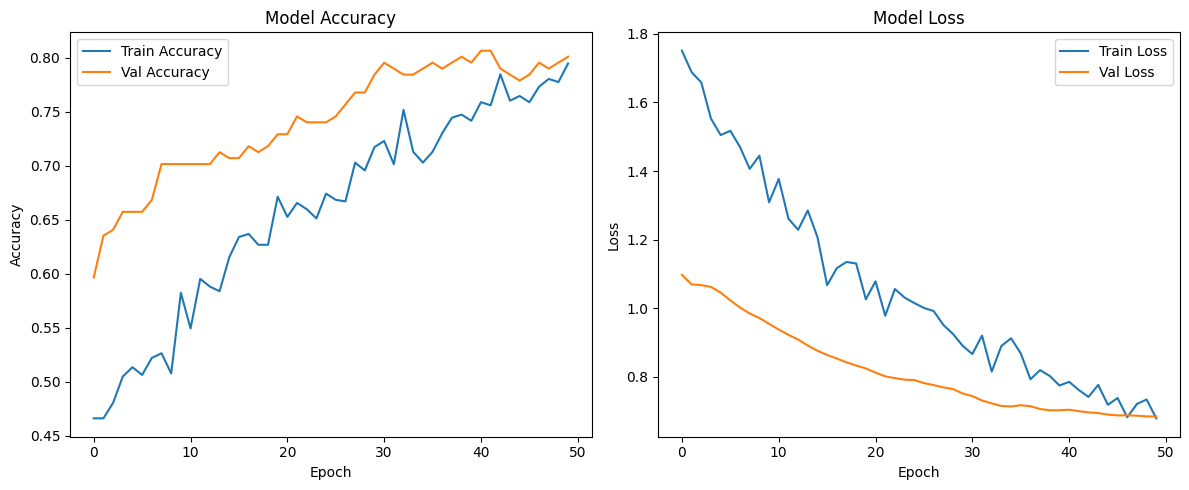

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call this after training
plot_training_history(history)



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# --- Get true labels ---
val_generator.reset()  # Reset generator to start from beginning
y_true = []
for _, labels in val_generator:
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= val_generator.samples:
        break
y_true = np.array(y_true)

# --- Get predicted labels ---
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Classification Report ---
print("Classification Report:\n")
print(classification_report(y_true, y_pred, zero_division=1))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# --- Additional Metrics ---
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='macro')

print("\nEvaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1 Score (macro):", f1)



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       1.00      1.00      1.00        21
           2       0.91      1.00      0.95        20
           3       0.74      0.85      0.79        20
           4       0.79      0.75      0.77        20
           5       0.65      0.55      0.59        20
           6       0.48      0.60      0.53        20
           7       1.00      0.95      0.97        20
           8       0.95      1.00      0.98        20

    accuracy                           0.80       181
   macro avg       0.80      0.80      0.80       181
weighted avg       0.80      0.80      0.80       181


Confusion Matrix:
 [[10  0  0  3  0  0  7  0  0]
 [ 0 21  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0]
 [ 0  0  1 17  0  0  1  0  1]
 [ 0  0  0  0 15  5  0  0  0]
 [ 0  0  0  0  4 11  5  0  0]
 [ 4  0  0  3  0  1 12  0  0]
 [

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       1.00      1.00      1.00        21
           2       0.91      1.00      0.95        20
           3       0.74      0.85      0.79        20
           4       0.79      0.75      0.77        20
           5       0.65      0.55      0.59        20
           6       0.48      0.60      0.53        20
           7       1.00      0.95      0.97        20
           8       0.95      1.00      0.98        20

    accuracy                           0.80       181
   macro avg       0.80      0.80      0.80       181
weighted avg       0.80      0.80      0.80       181

Confusion Matrix:
 [[10  0  0  3  0  0  7  0  0]
 [ 0 21  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0]
 [ 0  0  1 17  0  0  1  0  1]
 [ 0  0  0  0 15  5  0  0  0]
 [ 0  0  0  0  4 11  5  0  0]
 [ 4  0  0  3  0  1 12  0  0]
 [ 

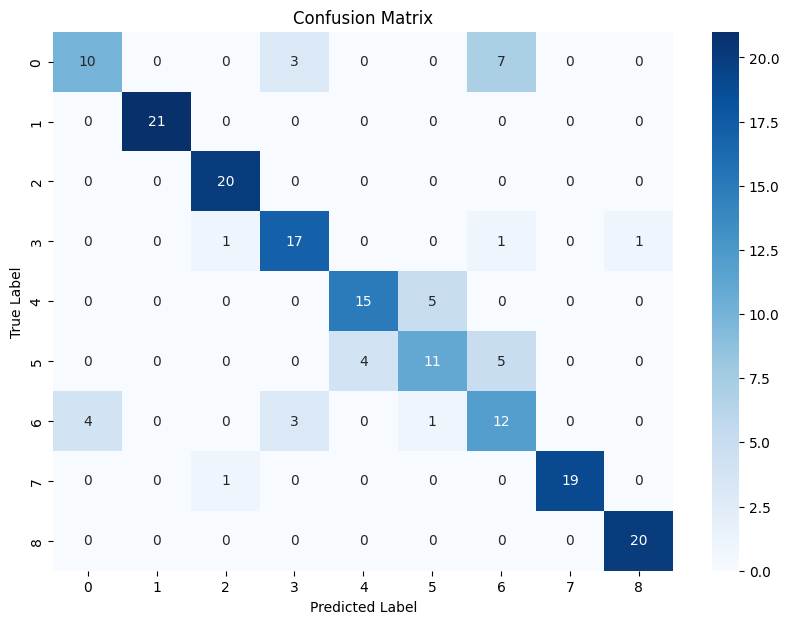


Evaluation Metrics:
Accuracy: 0.8011049723756906
Precision (macro): 0.8034911686977915
Recall (macro): 0.7999999999999999
F1 Score (macro): 0.7976045942813819


In [48]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reset the validation generator to make sure it starts from the beginning
val_generator.reset()

# Step 1: Get true labels from val_generator
y_val_classes = []
for i in range(len(val_generator)):
    _, labels = val_generator[i]
    y_val_classes.extend(np.argmax(labels, axis=1))
y_val_classes = np.array(y_val_classes)

# Step 2: Get predicted labels from model
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Step 3: Classification Report
print("Classification Report:\n")
print(classification_report(y_val_classes, y_pred_classes, zero_division=1))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Optional: Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 5: Additional Metrics
accuracy = accuracy_score(y_val_classes, y_pred_classes)
precision = precision_score(y_val_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_val_classes, y_pred_classes, average='macro', zero_division=1)
f1 = f1_score(y_val_classes, y_pred_classes, average='macro')

print("\nEvaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1 Score (macro):", f1)




In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on validation set
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [51]:
# Get the last epoch's training and validation accuracy and loss
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print them
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)
# CHAL THEAK HA ZADA GAP BHI NI HA ACCURACY MY DEKH RHI HA    HAAAAAN

Final Training Accuracy: 0.7948350310325623
Final Validation Accuracy: 0.8011049628257751
Final Training Loss: 0.678666353225708
Final Validation Loss: 0.6840748190879822


In [52]:
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 80.11%
